<a href="https://colab.research.google.com/github/xinmiaow/CPSC533R/blob/master/PyTorch_Turtorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CPSC 533R Visual AI - Turtorial


In [ ]:
# import standard PyTorch modules
import torch
import torch.nn as nn
import torch.optim as optim

# import torchvision module to handle image manipulation
import torchvision
import torchvision.transforms as transforms

# define a target device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device='cpu'
print(device)

cuda:0


In [ ]:
def gray_to_color(x):
    return x.repeat(3, 1, 1)

## Inheritance and overriding
### Customize a dataset
- Inherit a given dataset and override the `__getitem__()` method
- An example with [MNIST](https://pytorch.org/docs/1.1.0/_modules/torchvision/datasets/mnist.html)



In [ ]:
# define a wrapper of a given dataset
class myMNIST_wrapper(torch.utils.data.Dataset):
  def __init__(self, noise_range=0.3, *args, **kwargs):
    self.ds = torchvision.datasets.MNIST(*args, **kwargs)
    self.noise_range = noise_range
    print('The dataset is initialized.')
  def __getitem__(self,index):
    img, label = self.ds[index]

    # add some noise to the image 
    noise =  torch.randn_like(img)*self.noise_range
    noisy_img = noise + img
    noisy_img[noisy_img>1]=1
    noisy_img[noisy_img<0]=0

    # return both original image and the noisy one
    return img, noisy_img, label, label%2, index

  def __len__(self):
    return len(self.ds)

# OR just inherit the given dataset directly
class myMNIST(torchvision.datasets.MNIST):
  # override the constructor
  def __init__(self, noise_range=0.3, *args, **kwargs):
    # initialize with the `__init__()` from the father class
    super().__init__(*args, **kwargs)
    self.noise_range = noise_range
    print('The dataset is initialized.')
  def __getitem__(self, index):

    # get the item with the `__getitem__` of father class
    img, label = super().__getitem__(index)

    # add some noise to the image 
    noise =  torch.randn_like(img)*self.noise_range
    noisy_img = noise+img
    noisy_img[noisy_img>1]=1
    noisy_img[noisy_img<0]=0

    # return both original image and the noisy one
    return img, noisy_img, label, label%2, index
  # don't need to override __len__ if the dataset still has the same size 



In [ ]:
# train_set = myMNIST_wrapper(
train_set = myMNIST(
    root = './DatasetMNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor(),
        # gray_to_color,
      ])
    )


The dataset is initialized.


0 torch.Size([1, 28, 28])
1 torch.Size([1, 28, 28])
2 3
3 1
4 10


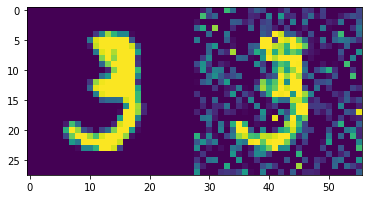

In [ ]:
import matplotlib.pyplot as plt

idx  = 10
sample  = train_set[idx]
for i,v in enumerate(sample):
  if isinstance(v,torch.Tensor):
    print(i,v.shape)
  else:
    print(i,v)

plt.imshow(torch.cat([sample[0],
          sample[1]],dim=2).numpy().squeeze())

### Dataloader parameters
- `batch_size`
- `pin_memory`
- `shuffle`
- `drop_last`

moving data from cpu to gpu 

In [ ]:
# helper function for moving batch to tareget device
def batch_to_device(batch,device):
  for i,v in enumerate(batch):
    # print(i,v)
    batch[i] = v.to(device)
  return batch 



# define the dataloader
train_loader = torch.utils.data.DataLoader(train_set, 
                      shuffle=False, 
                      batch_size = 7, 
                      pin_memory=False,
                      drop_last=False)

print(len(train_set)/train_loader.batch_size)
print(len(train_loader))


8571.42857142857
8572


In [ ]:
# get a batch
iterator = iter(train_loader)
batch = next(iterator)

# print some information of the batch
print([(batch[i].shape, batch[i].device) for i,_ in enumerate(batch)])

# move the tuple to target device 
batch_to_device(batch, device)
print([(batch[i].shape, batch[i].device) for i,_ in enumerate(batch)])
print(batch[-1])

[(torch.Size([7, 1, 28, 28]), device(type='cpu')), (torch.Size([7, 1, 28, 28]), device(type='cpu')), (torch.Size([7]), device(type='cpu')), (torch.Size([7]), device(type='cpu')), (torch.Size([7]), device(type='cpu'))]
[(torch.Size([7, 1, 28, 28]), device(type='cuda', index=0)), (torch.Size([7, 1, 28, 28]), device(type='cuda', index=0)), (torch.Size([7]), device(type='cuda', index=0)), (torch.Size([7]), device(type='cuda', index=0)), (torch.Size([7]), device(type='cuda', index=0))]
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


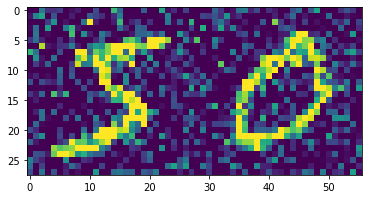

In [ ]:
sample = batch[1]
plt.imshow(torch.cat([sample[0],
          sample[1]],dim=2).cpu().numpy().squeeze())

### Customize networks
- Define a model from scratch 
- Inherit a given class and override the `forward()` method

In [ ]:
# define a model from scratch:
class myNN(nn.Module):
  def __init__(self, in_features=28*28, latent_dim= 128, out_dim=2, activation_layer=nn.ReLU()):
    # define a simple structure
    super().__init__()
    
    self.in_features = in_features
    self.out_dim = out_dim
    self.latent_dim = latent_dim
    self.activation_layer = activation_layer

    self.fc = nn.Sequential(
            nn.Linear(in_features=self.in_features, out_features=self.latent_dim*4),
            self.activation_layer,
            nn.Linear(in_features=self.latent_dim*4, out_features=self.latent_dim*2),
            self.activation_layer,
            nn.Linear(in_features=self.latent_dim*2, out_features=self.latent_dim),
            self.activation_layer,
            nn.Linear(in_features=self.latent_dim, out_features=self.out_dim),
        )
  def forward(self, batch):
    # print(batch.shape)
    x = batch.flatten(start_dim=1,end_dim=-1)
    # print(x.shape)
    x = self.fc(x)
    # print(x.shape)

    return x

# define a wrapper for myNN which takes a tuple batch
class myNN_tuple(myNN):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)

    # add a layer to the top
    fc_layers = list(self.fc)
    fc_layers.insert(1,nn.Dropout(p=0.5))
    self.fc = nn.Sequential(*fc_layers)

  def forward(self, batch):
    y = super().forward(batch[0])
    y_noisy = super().forward(batch[1])
    return {'pred':y, 'pred_noisy':y_noisy}

In [ ]:
model_1 = myNN()
print(model_1)
model_1.eval()
input = torch.randn(5,1,28,28)
print(input.shape)
with torch.no_grad(): 
  result =model_1(input)
print(result)
# model_1(batch)

myNN(
  (activation_layer): ReLU()
  (fc): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=2, bias=True)
  )
)
torch.Size([5, 1, 28, 28])
tensor([[0.0588, 0.1035],
        [0.0050, 0.0865],
        [0.0132, 0.1018],
        [0.0720, 0.1262],
        [0.0495, 0.1028]])


In [ ]:
model_2 = myNN_tuple(activation_layer=nn.Tanh()).to(device)
print(model_2)
# model_2.eval()
model_2.train()
result =model_2(batch)
print(result)

myNN_tuple(
  (activation_layer): Tanh()
  (fc): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): Tanh()
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): Tanh()
    (5): Linear(in_features=256, out_features=128, bias=True)
    (6): Tanh()
    (7): Linear(in_features=128, out_features=2, bias=True)
  )
)
{'pred': tensor([[ 0.0621, -0.0518],
        [ 0.0713,  0.0096],
        [ 0.1006,  0.0069],
        [ 0.0552,  0.0388],
        [ 0.0489, -0.0205],
        [ 0.0636, -0.0229],
        [ 0.0623, -0.0349]], device='cuda:0', grad_fn=<AddmmBackward>), 'pred_noisy': tensor([[ 0.0615, -0.0125],
        [ 0.0080, -0.0394],
        [ 0.0739, -0.0806],
        [ 0.0741,  0.0432],
        [-0.0063, -0.0192],
        [ 0.0217,  0.0415],
        [ 0.0131,  0.0318]], device='cuda:0', grad_fn=<AddmmBackward>)}


### `model.eval()` and `model.train()`
- important if you have batchnorm or dropout layers

what will happen define optimizer inside the loop
- momentum will lose if you are using optimizers with momentum, e.g., Adam

tricks that save GPU memory
- `torch.no_grad()`
  - gradients cost memory, try `with torch.no_grad():` when you don't need gradients 
- `loss.item()`
  - when track the loss curve, save the number of loss instead of the loss object
- `torch.cuda.empty_cache()`
  - clear the cache 

a sample pipeline for trainning a model

```
for someHyperParam in HyperParamList:
  
  # clear some meomory cache
  model=None
  torch.cuda.empty_cache()

  model = someModelClass(someHyperParam)
  optimizer = optim.SGD(model.parameters(), otherHyperParam)
  losses_train = []

  for e in epochs:
    for i,batch in enumerare(loader):
      
      model.train()
      
      pred = model(batch)
      loss = loss_fucntion(pred,batch)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # track the training loss
      losses_train.append(loss.item())


      # evaluate the model on validation set every plot_every iterations
      if i % plot_every == 0:
        model.eval()
        with torch.no_grad():
          # evaluation part
          # plot the result
  
  # save trained parameters
  torch.save(model.state_dict(),model_path)

```



### Tensor Broadcasting
- https://pytorch.org/docs/stable/notes/broadcasting.html

In [ ]:
a = torch.arange(10).unsqueeze(1).float()
a.requires_grad=True
b = torch.arange(10).unsqueeze(0).float()
b.requires_grad=True
print(a,b)
d = torch.abs(a-b)
print(d)
# print(d.grad_fn)
# d.mean().backward()
# a.grad

tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.],
        [6.],
        [7.],
        [8.],
        [9.]], requires_grad=True) tensor([[0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]], requires_grad=True)
tensor([[0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
        [1., 0., 1., 2., 3., 4., 5., 6., 7., 8.],
        [2., 1., 0., 1., 2., 3., 4., 5., 6., 7.],
        [3., 2., 1., 0., 1., 2., 3., 4., 5., 6.],
        [4., 3., 2., 1., 0., 1., 2., 3., 4., 5.],
        [5., 4., 3., 2., 1., 0., 1., 2., 3., 4.],
        [6., 5., 4., 3., 2., 1., 0., 1., 2., 3.],
        [7., 6., 5., 4., 3., 2., 1., 0., 1., 2.],
        [8., 7., 6., 5., 4., 3., 2., 1., 0., 1.],
        [9., 8., 7., 6., 5., 4., 3., 2., 1., 0.]], grad_fn=<AbsBackward>)


In [ ]:
# Simple example: calculate pairwise distance between points
pos = torch.randn((5,2),requires_grad=True)
print(pos)
a = pos.unsqueeze(1)
b = pos.unsqueeze(0)
print(a.shape,b.shape)

# dist_mat = torch.sqrt(((a-b)**2).sum(-1))
dist_mat = ((a-b)**2).sum(-1)
dist_mat = torch.abs((a-b).sum(-1))
print(dist_mat)

tensor([[ 0.9896, -0.3892],
        [-1.0116, -0.4939],
        [-2.2526,  0.9108],
        [ 0.2841,  0.3821],
        [-2.0991,  0.7806]], requires_grad=True)
torch.Size([5, 1, 2]) torch.Size([1, 5, 2])
tensor([[0.0000, 2.1059, 1.9422, 0.0658, 1.9189],
        [2.1059, 0.0000, 0.1637, 2.1716, 0.1870],
        [1.9422, 0.1637, 0.0000, 2.0080, 0.0233],
        [0.0658, 2.1716, 2.0080, 0.0000, 1.9847],
        [1.9189, 0.1870, 0.0233, 1.9847, 0.0000]], grad_fn=<AbsBackward>)


In [ ]:
# # optimizer = optim.SGD([pos],lr=0.1)
# loss = dist_mat.mean()
# # loss = pos.mean()

# # optimizer.zero_grad()
# loss.backward()
# # optimizer.step()

# print(loss,pos.grad)

tensor(1.0057, grad_fn=<MeanBackward0>) tensor([[ 0.1600,  0.1600],
        [-0.3200, -0.3200],
        [-0.1600, -0.1600],
        [ 0.3200,  0.3200],
        [ 0.0000,  0.0000]])
